In [1]:
import math
import os
from tempfile import TemporaryDirectory
from typing import Tuple

import torch
from torch import nn, Tensor
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset

import torch.nn.functional as F

#plotting
import matplotlib.pyplot as plt

import data_utils
import models
import importlib
import transformer_models
importlib.reload(data_utils)
importlib.reload(models)
importlib.reload(transformer_models)
from data_utils import *
from models import *
from transformer_models import * 
import torch.optim as optim
from torch.utils.data import DataLoader
import datetime
from tqdm import tqdm 
import pickle
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
data_dir = "data/"
dataObject = xrdData("data/", device, datasets_avail=['train', 'val', 'test'])

dataObject.make_datasets(1, composition_embedding="compositionseq")
# Create DataLoaders for train and validation sets
train_loader = DataLoader(dataObject.torch_datasets['train'], batch_size=32, shuffle=True)
test_loader = DataLoader(dataObject.torch_datasets['test'], batch_size=32, shuffle=False)  

In [3]:
pickle_path = 'comp_eval_results1.pkl'

# load existing data from pickle file
def load_data(pickle_path):
    try:
        with open(pickle_path, 'rb') as f:
            return pickle.load(f)
    except (EOFError, FileNotFoundError):
        return []  

# save data to a pickle file
def save_data(data, pickle_path):
    with open(pickle_path, 'wb') as f:
        pickle.dump(data, f)


In [4]:
crop_starts_stops = [300, 500, 700, 900, 1100]  
noise_levels = [0.1, 0.2, 0.3, 0.4, 0.5]
drop_freqs = [2, 4, 8, 16, 32] 

log = load_data(pickle_path)

# Training loop with noise level variation
for i in range(5):

    output_dim = 230  # Output dimension
    token_size = 10 #dimension of the tokens 
    TransModel = FullModel(ntoken = output_dim, d_model = token_size, nhead = 10, d_hid=50, nlayers=1, dropout = 0.5).to(device)
    model = TransModel

    weight_decay = 1e-3 
    optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    max_epochs = 100
    metrics = ["accuracy", "loss"]

    crop_start = crop_starts_stops[i]
    crop_stop = crop_starts_stops[i] 
    noise_level = noise_levels[i]
    drop_freq = drop_freqs[i]
    
    print(f"Run {i+1}: Crop Start/Stop: {crop_start}, Noise Level: {noise_level}, Drop Frequency: {drop_freq}")
    run_data = {'run': i+1, 'parameters': {'crop_start': crop_start, 'noise_level': noise_level, 'drop_freq': drop_freq}, 'epochs': []}
   
    simulator = ExperimentalSimulation(device, crop_start=crop_start, crop_stop=crop_stop, noise_range=noise_level, drop_width=100, drop_freq=drop_freq)
    
    for epoch in range(max_epochs):
        model.train()  
        total_train_loss = 0
        correct_train = 0
        total_train = 0

        for xrd, composition, targets in tqdm(train_loader):
            xrd = simulator.sim(xrd)
            optimizer.zero_grad()
            outputs = model(xrd)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += targets.size(0)
            correct_train += (predicted == targets).sum().item()

        train_accuracy = 100 * correct_train / total_train
        print(f"Epoch {epoch+1} Training Loss: {total_train_loss}, Training Accuracy: {train_accuracy}")

        run_data['epochs'].append({
        'epoch': epoch,
        'type': 'Train',
        'train_accuracy': train_accuracy,
        'train_loss': total_train_loss
        })

    # Validation 
    model.eval()  # Set the model to evaluation mode
    total_test_loss = 0
    correct_test = 0
    total_test = 0

    with torch.no_grad(): 
        for xrd, composition, targets in tqdm(test_loader):
            xrd = simulator.sim(xrd)
            outputs = model(xrd)
            loss = criterion(outputs, targets)
            total_test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1) 
            total_test += targets.size(0)
            correct_test += (predicted == targets).sum().item()

    test_accuracy = 100 * correct_test / total_test

    log.append(test_accuracy)

12160
torch.Size([40, 80])
torch.Size([80, 40])
Run 1: Crop Start/Stop: 300, Noise Level: 0.1, Drop Frequency: 2


100%|██████████| 720/720 [00:26<00:00, 27.38it/s]


Epoch 1 Training Loss: 3174.029606103897, Training Accuracy: 12.476124327140129


100%|██████████| 720/720 [00:25<00:00, 28.49it/s]


Epoch 2 Training Loss: 2711.984577178955, Training Accuracy: 16.56103490189269


100%|██████████| 720/720 [00:25<00:00, 28.07it/s]


Epoch 3 Training Loss: 2557.3737177848816, Training Accuracy: 19.417433582219136


100%|██████████| 720/720 [00:26<00:00, 27.66it/s]


Epoch 4 Training Loss: 2464.391585826874, Training Accuracy: 21.119117902413613


100%|██████████| 720/720 [00:25<00:00, 28.21it/s]


Epoch 5 Training Loss: 2396.758888244629, Training Accuracy: 22.48654280256989


100%|██████████| 720/720 [00:25<00:00, 28.11it/s]


Epoch 6 Training Loss: 2343.6036310195923, Training Accuracy: 23.432887654106615


100%|██████████| 720/720 [00:25<00:00, 28.15it/s]


Epoch 7 Training Loss: 2295.2575602531433, Training Accuracy: 24.73085605139781


100%|██████████| 720/720 [00:24<00:00, 28.90it/s]


Epoch 8 Training Loss: 2245.417295217514, Training Accuracy: 25.790067720090292


100%|██████████| 720/720 [00:25<00:00, 28.55it/s]


Epoch 9 Training Loss: 2200.6957325935364, Training Accuracy: 27.08803611738149


100%|██████████| 720/720 [00:25<00:00, 28.79it/s]


Epoch 10 Training Loss: 2158.460910320282, Training Accuracy: 28.264455634658795


100%|██████████| 720/720 [00:25<00:00, 28.31it/s]


Epoch 11 Training Loss: 2130.092121243477, Training Accuracy: 28.967702726167737


100%|██████████| 720/720 [00:25<00:00, 28.67it/s]


Epoch 12 Training Loss: 2081.604752779007, Training Accuracy: 30.122417086299706


100%|██████████| 720/720 [00:25<00:00, 28.34it/s]


Epoch 13 Training Loss: 2041.151275396347, Training Accuracy: 31.79371418649071


100%|██████████| 720/720 [00:24<00:00, 29.65it/s]


Epoch 14 Training Loss: 2016.222944021225, Training Accuracy: 32.68796666087862


100%|██████████| 720/720 [00:24<00:00, 29.46it/s]


Epoch 15 Training Loss: 1983.4345177412033, Training Accuracy: 33.66469873241882


100%|██████████| 720/720 [00:25<00:00, 28.32it/s]


Epoch 16 Training Loss: 1955.9402046203613, Training Accuracy: 34.11616600104185


100%|██████████| 720/720 [00:25<00:00, 28.33it/s]


Epoch 17 Training Loss: 1924.2362875938416, Training Accuracy: 35.079874978294846


100%|██████████| 720/720 [00:24<00:00, 28.91it/s]


Epoch 18 Training Loss: 1900.8212502002716, Training Accuracy: 36.2085431498524


100%|██████████| 720/720 [00:25<00:00, 28.75it/s]


Epoch 19 Training Loss: 1863.4058681726456, Training Accuracy: 36.76853620420212


100%|██████████| 720/720 [00:25<00:00, 28.47it/s]


Epoch 20 Training Loss: 1842.585689663887, Training Accuracy: 37.59333217572495


100%|██████████| 720/720 [00:25<00:00, 28.75it/s]


Epoch 21 Training Loss: 1817.9101303815842, Training Accuracy: 38.41378711581872


100%|██████████| 720/720 [00:24<00:00, 28.91it/s]


Epoch 22 Training Loss: 1796.4460626840591, Training Accuracy: 38.817503038722


100%|██████████| 720/720 [00:25<00:00, 28.64it/s]


Epoch 23 Training Loss: 1775.1463123559952, Training Accuracy: 39.39486021878798


100%|██████████| 720/720 [00:25<00:00, 28.43it/s]


Epoch 24 Training Loss: 1752.818454504013, Training Accuracy: 39.88105573884355


100%|██████████| 720/720 [00:25<00:00, 28.39it/s]


Epoch 25 Training Loss: 1732.0470513105392, Training Accuracy: 40.84042368466748


100%|██████████| 720/720 [00:25<00:00, 28.45it/s]


Epoch 26 Training Loss: 1711.9307737350464, Training Accuracy: 41.45685014759507


100%|██████████| 720/720 [00:25<00:00, 28.30it/s]


Epoch 27 Training Loss: 1688.5898571014404, Training Accuracy: 42.38583087341552


100%|██████████| 720/720 [00:25<00:00, 28.48it/s]


Epoch 28 Training Loss: 1669.1110476255417, Training Accuracy: 42.68102101059212


100%|██████████| 720/720 [00:25<00:00, 28.67it/s]


Epoch 29 Training Loss: 1652.7843835353851, Training Accuracy: 43.02830352491752


100%|██████████| 720/720 [00:25<00:00, 28.50it/s]


Epoch 30 Training Loss: 1633.5167182683945, Training Accuracy: 43.492793887827744


100%|██████████| 720/720 [00:25<00:00, 28.61it/s]


Epoch 31 Training Loss: 1610.4302705526352, Training Accuracy: 44.32627192220872


100%|██████████| 720/720 [00:25<00:00, 28.51it/s]


Epoch 32 Training Loss: 1590.8693351745605, Training Accuracy: 44.73432887654106


100%|██████████| 720/720 [00:25<00:00, 28.46it/s]


Epoch 33 Training Loss: 1573.9249740839005, Training Accuracy: 45.4115297794756


100%|██████████| 720/720 [00:25<00:00, 28.37it/s]


Epoch 34 Training Loss: 1556.8253984451294, Training Accuracy: 45.75013023094287


100%|██████████| 720/720 [00:25<00:00, 28.26it/s]


Epoch 35 Training Loss: 1540.9606662988663, Training Accuracy: 46.0670255252648


100%|██████████| 720/720 [00:25<00:00, 28.31it/s]


Epoch 36 Training Loss: 1521.094678401947, Training Accuracy: 47.02639347108873


100%|██████████| 720/720 [00:25<00:00, 28.28it/s]


Epoch 37 Training Loss: 1508.1684769392014, Training Accuracy: 47.41274526827574


100%|██████████| 720/720 [00:25<00:00, 28.31it/s]


Epoch 38 Training Loss: 1489.2153522968292, Training Accuracy: 47.86421253689877


100%|██████████| 720/720 [00:25<00:00, 28.26it/s]


Epoch 39 Training Loss: 1480.9177842140198, Training Accuracy: 48.011807605487064


100%|██████████| 720/720 [00:25<00:00, 28.31it/s]


Epoch 40 Training Loss: 1459.5521503686905, Training Accuracy: 48.589164785553045


100%|██████████| 720/720 [00:25<00:00, 28.28it/s]


Epoch 41 Training Loss: 1445.1339911818504, Training Accuracy: 48.975516582740056


100%|██████████| 720/720 [00:25<00:00, 28.35it/s]


Epoch 42 Training Loss: 1435.7844178676605, Training Accuracy: 49.14047577704463


100%|██████████| 720/720 [00:25<00:00, 28.76it/s]


Epoch 43 Training Loss: 1415.6905071735382, Training Accuracy: 50.221392602882446


100%|██████████| 720/720 [00:25<00:00, 28.34it/s]


Epoch 44 Training Loss: 1402.7749698162079, Training Accuracy: 50.395033860045146


100%|██████████| 720/720 [00:25<00:00, 28.15it/s]


Epoch 45 Training Loss: 1387.842657983303, Training Accuracy: 50.989755165827404


100%|██████████| 720/720 [00:25<00:00, 28.40it/s]


Epoch 46 Training Loss: 1375.6176270246506, Training Accuracy: 51.36308386872721


100%|██████████| 720/720 [00:25<00:00, 28.61it/s]


Epoch 47 Training Loss: 1368.4367476701736, Training Accuracy: 51.376106963014415


 93%|█████████▎| 670/720 [00:21<00:01, 31.17it/s]


KeyboardInterrupt: 

In [26]:
data = load_data(pickle_path)
len(data)

5

In [27]:
import pandas as pd

rows = []
for run in data:  
    for epoch in run['epochs']: 
        row = {
            'run': run['run'],
            'type': epoch['type'],
            'crop_start': run['parameters']['crop_start'],
            'noise_level': run['parameters']['noise_level'],
            'drop_freq': run['parameters']['drop_freq'],
            'epoch': epoch['epoch'],
            
        }
        if epoch['type'] == 'Train':
            row.update({
                'accuracy': epoch.get('train_accuracy'),
                'loss': epoch.get('train_loss')
            })
        elif epoch['type'] == 'Validation':
            row.update({
                'accuracy': epoch.get('valid_accuracy'),
                'loss': epoch.get('valid_loss')
            })
        rows.append(row)
df = pd.DataFrame(rows) 
df

run        type  crop_start  noise_level  drop_freq  epoch   accuracy  \
0      1       Train         300          0.1          2      0  96.611111   
1      1  Validation         300          0.1          2      0  56.965303   
2      1       Train         300          0.1          2      1  97.392157   
3      1  Validation         300          0.1          2      1  57.690316   
4      1       Train         300          0.1          2      2  97.532680   
..   ...         ...         ...          ...        ...    ...        ...   
995    5  Validation        1100          0.5         32     97  40.626618   
996    5       Train        1100          0.5         32     98  49.369281   
997    5  Validation        1100          0.5         32     98  38.917659   
998    5       Train        1100          0.5         32     99  49.297386   
999    5  Validation        1100          0.5         32     99  40.082859   

         loss  
0    0.120349  
1    2.097724  
2    0.092780  
3    2.144112  
4    0.088671  
..        ...  
995  2.466288  
996  1.937607  
997  2.453170  
998  1.942140  
999  2.453204  

[1000 rows x 8 columns]

Text(0.5, 1.0, 'Training and Validation Loss')

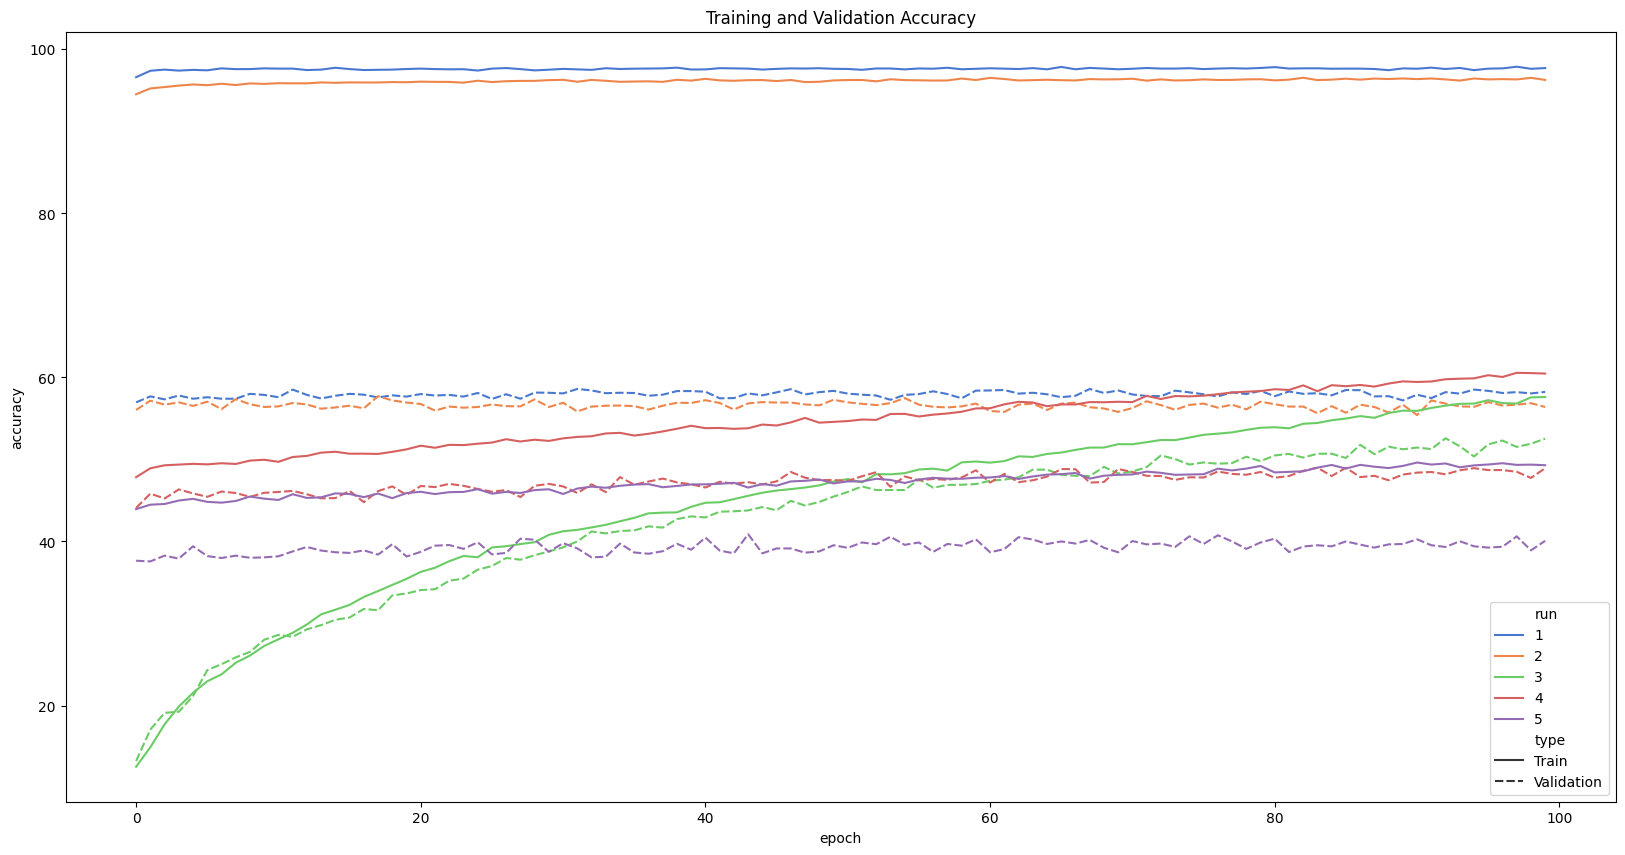

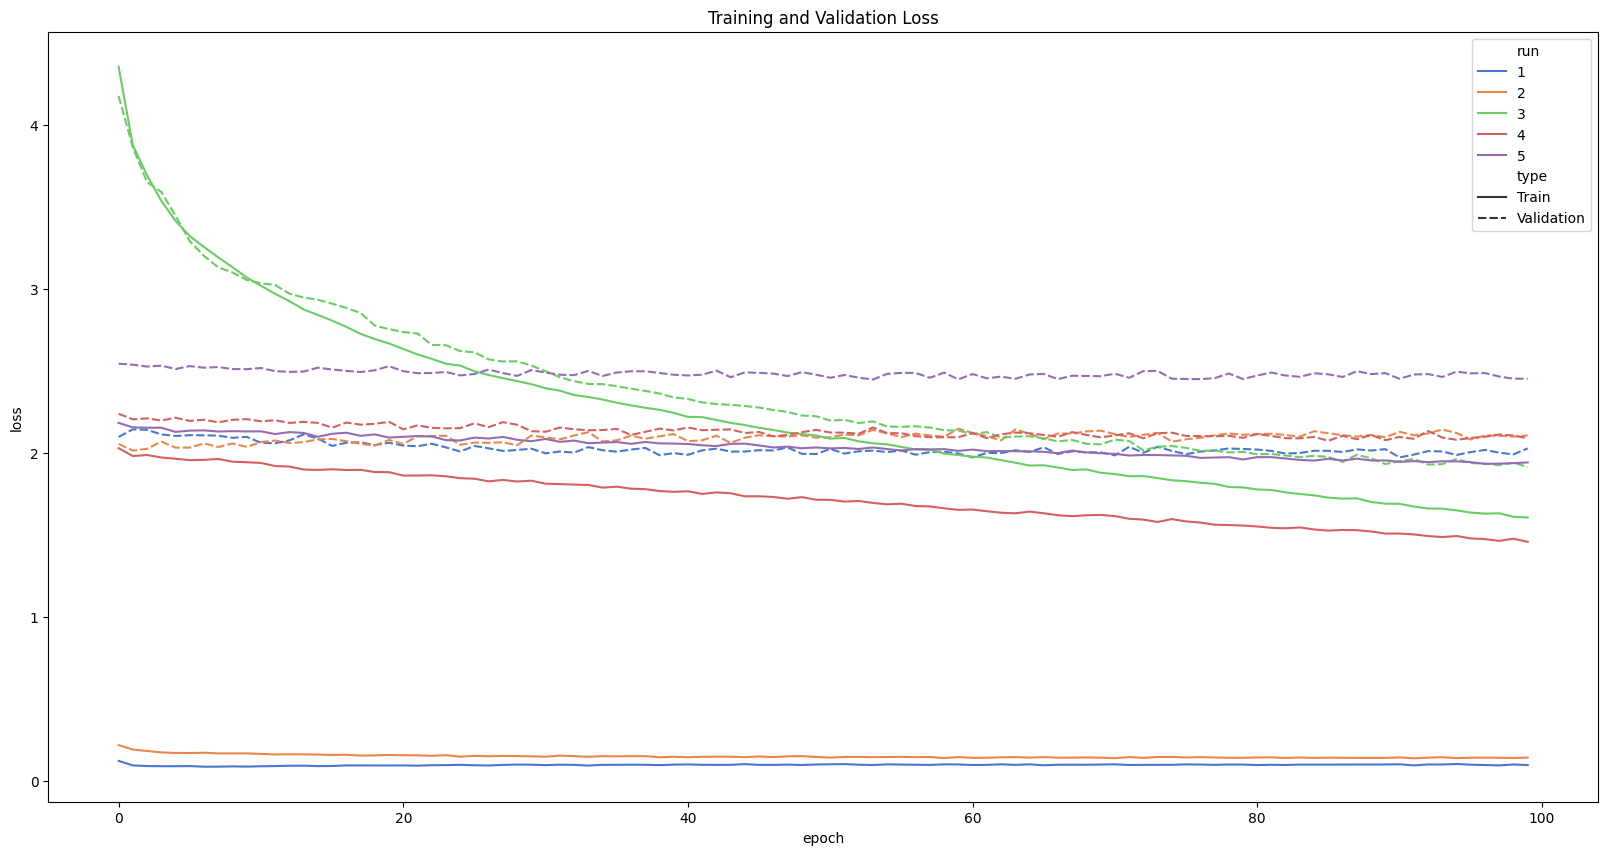

In [30]:
import seaborn as sns

# plot training and validation accuracy
plt.figure(figsize=(20, 10))
sns.lineplot(data=df, x='epoch', y='accuracy', hue='run', style='type', palette='muted')
plt.title('Training and Validation Accuracy')

# plot training and validation loss
plt.figure(figsize=(20, 10))
sns.lineplot(data=df, x='epoch', y='loss', hue='run', style='type', palette='muted')
plt.title('Training and Validation Loss')
